In [1]:
%load_ext autoreload
%autoreload 2
from evaluation.face_recognition_test import Face_Fecognition_test
from evaluation.ijb_evals import instantiate_list
from omegaconf import OmegaConf
from pathlib import Path
import numpy as np
from evaluation.visualize import (
    plot_dir_far_scores,
    plot_cmc_scores,
    plot_rejection_scores,
)
from evaluation.confidence_functions import MisesProb
from hydra.utils import instantiate

In [2]:
cfg = OmegaConf.load("/app/configs/uncertainty_benchmark/ijb_evals.yaml")
method = cfg.open_set_identification_methods[0]
sampler = instantiate(method.sampler)
evaluation_function = instantiate(method.evaluation_function)
assert evaluation_function is not None
# if cfg.test_dataset.dataset_name == "survFace" and method.use_detector_score:
#     continue
template_pooling = instantiate(method.template_pooling_strategy)

In [3]:
open_set_identification_metrics = instantiate_list(cfg.open_set_identification_metrics)
if "open_set_uncertainty_metrics" in cfg:
    open_set_uncertainty_metrics = instantiate_list(cfg.open_set_uncertainty_metrics)
else:
    open_set_uncertainty_metrics = []

test_dataset = instantiate(cfg.test_dataset)

# create result dirs:
dataset_name = cfg.test_dataset.dataset_name
open_set_identification_result_dir = (
    Path(cfg.exp_dir) / dataset_name / "open_set_identification"
)
open_set_identification_result_dir.mkdir(exist_ok=True, parents=True)

tt = Face_Fecognition_test(
    sampler=sampler,
    evaluation_function=evaluation_function,
    test_dataset=test_dataset,
    embeddings_path=method.embeddings_path,
    template_pooling_strategy=template_pooling,
    use_detector_score=method.use_detector_score,
    use_two_galleries=cfg.use_two_galleries,
    recompute_template_pooling=cfg.recompute_template_pooling,
    open_set_identification_metrics=open_set_identification_metrics,
    closed_set_identification_metrics=None,
    verification_metrics=None,
    open_set_uncertainty_metrics=open_set_uncertainty_metrics,
)

In [4]:
(
    g1_templates_feature,
    g1_template_unc,
    g1_unique_ids,
) = tt.get_template_subsets(tt.test_dataset.g1_templates, tt.test_dataset.g1_ids)

(
    probe_templates_feature,
    probe_template_unc,
    probe_unique_ids,
) = tt.get_template_subsets(tt.test_dataset.probe_templates, tt.test_dataset.probe_ids)

# sample probe feature vectors

probe_templates_feature = tt.sampler(
    probe_templates_feature,
    probe_template_unc,
)

In [5]:
similarity, probe_score = tt.evaluation_function(
    probe_templates_feature,
    probe_template_unc,
    g1_templates_feature,
    g1_template_unc,
)

In [6]:
similarity.shape

(19593, 1, 1772)

In [7]:
gallery_ids = g1_unique_ids
gallery_ids_argsort = np.argsort(gallery_ids)
gallery_ids_sorted = gallery_ids[gallery_ids_argsort]

gallery_ids_sorted = np.concatenate([gallery_ids_sorted, [-1]]) # last id is for out of gallery
probe_ids = probe_unique_ids 
is_seen = np.isin(probe_ids, gallery_ids)
seen_probe_ids = probe_ids[is_seen]
def compute_von_Mises_tar_far(kappa, beta):
    mises_maxprob = MisesProb(kappa=kappa, beta=beta)
    all_classes_log_prob = mises_maxprob.compute_all_class_log_probabilities(
                similarity
            )
    all_classes_log_prob = all_classes_log_prob[:, 0, :]

    # make pred
    # sort labels
    all_classes_log_prob[:, :-1] = all_classes_log_prob[:, :-1][:, gallery_ids_argsort]
    predict_id = np.argmax(all_classes_log_prob, axis=-1)
    # far
    far = np.mean(predict_id[~is_seen]!=similarity.shape[-1])
    tar = np.mean(gallery_ids_sorted[predict_id[is_seen]] == seen_probe_ids)
    return tar, far
    

In [10]:
from itertools import product
from tqdm import tqdm
kappas = np.linspace(100,800,5)
betas = np.logspace(-3.0, -0.01, num=5)
print(len(kappas) * len(betas))
kappa_beta_to_tar_far = {}
for kappa, beta in tqdm(product(kappas, betas), total=len(kappas) * len(betas)):
    tar, far = compute_von_Mises_tar_far(kappa=kappa, beta=beta)
    #print(f'tar-{tar} at far-{far} with kappa-{kappa} and beta {beta}')
    kappa_beta_to_tar_far[(kappa, beta)] = (tar, far)

  0%|          | 0/25 [00:00<?, ?it/s]

25


 80%|████████  | 20/25 [00:59<00:14,  2.81s/it]/app/evaluation/confidence_functions.py:52: RuntimeWarning: overflow encountered in exp
  np.sum(np.exp(similarities * self.kappa), axis=-1) * (1 - self.beta) / K
100%|██████████| 25/25 [01:13<00:00,  2.96s/it]


In [11]:
tars = np.array([kappa_beta_to_tar_far[key][0] for key in kappa_beta_to_tar_far])
fars = np.array([kappa_beta_to_tar_far[key][1] for key in kappa_beta_to_tar_far])

far_sort_idx = np.argsort(fars)
fars = fars[far_sort_idx]
tars = tars[far_sort_idx]

In [12]:
a = np.load('/app/outputs/experiments/open_set_uncertainty_without_thresh/IJBC/open_set_identification/Cosine_recalls_1_rank.npz')

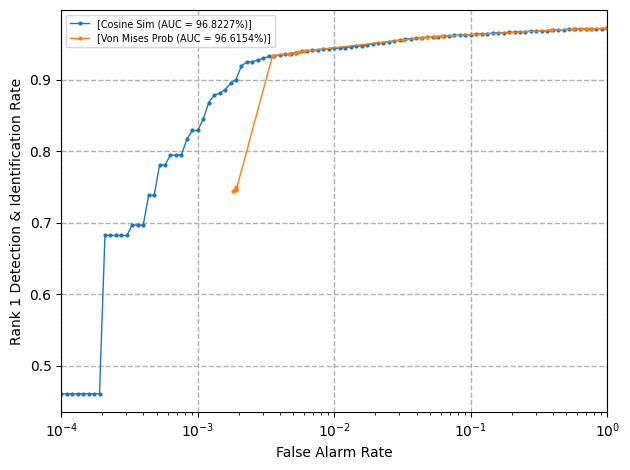

In [16]:
scores = [(a['fars'], a['recalls']) , (fars, tars)]
model_names = ['Cosine Sim', 'Von Mises Prob']
fig = plot_dir_far_scores(
            scores=scores,
            names=model_names,
            y_label=f"Rank 1 Detection & Identification Rate",
            marker='o'
        )
fig.savefig(f"dir_plot.png", dpi=300)

### Make prediction via max prob

In [ ]:
print(f'tar-{tar} at far-{far} with kappa-{kappa} and beta {beta}')

tar-0.9407445708376422 at far-0.006248110450468608 with kappa-600 and beta 0.1


In [ ]:
1

1

/home/erlygin/miniconda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


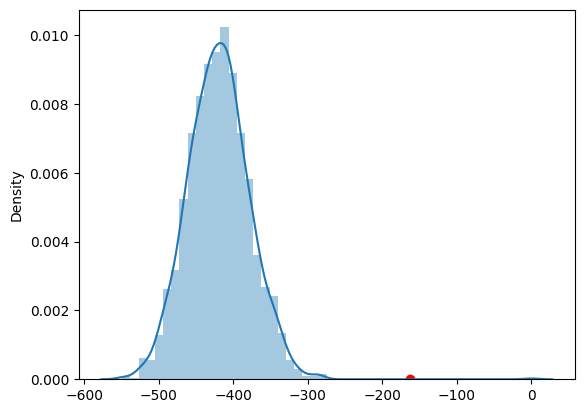

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.distplot(
    all_classes_log_prob[0, :-1],
    kde=True,
    norm_hist=True,
    hist=True,
    label='0',
)
plt.scatter([all_classes_log_prob[0, -1]], [0], c='red')

In [ ]:
all_classes_log_prob

array([[ 0.00000000e+00, -4.56860104e+02, -4.02662991e+02, ...,
        -4.29303546e+02, -4.33216700e+02, -1.62532277e+02],
       [ 2.27373675e-13, -4.56410412e+02, -4.20646312e+02, ...,
        -4.42817680e+02, -4.65000715e+02, -1.84187387e+02],
       [ 2.27373675e-13, -5.06488040e+02, -4.33610012e+02, ...,
        -4.53479475e+02, -4.27899770e+02, -1.75930682e+02],
       ...,
       [-3.02988064e+02, -2.17529972e+02, -2.40910777e+02, ...,
        -2.22992910e+02, -2.56822927e+02,  0.00000000e+00],
       [-3.24487991e+02, -2.19425882e+02, -2.83723880e+02, ...,
        -2.19588871e+02, -2.67937981e+02,  0.00000000e+00],
       [-3.05668089e+02, -2.18835223e+02, -2.60080197e+02, ...,
        -2.18117005e+02, -2.46300834e+02,  0.00000000e+00]])